Dataset : https://finance.yahoo.com/quote/%5ENSEI/history?period1=1609459200&period2=1705968000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true




In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

In [36]:

df = pd.read_csv("https://raw.githubusercontent.com/sankhla2/Intro-to-Financial/main/NSEI.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-25,14477.799805,14491.099609,14218.599609,14238.900391,14238.900391,618600.0
1,2021-01-27,14237.950195,14237.950195,13929.299805,13967.500000,13967.500000,660700.0
2,2021-01-28,13810.400391,13898.250000,13713.250000,13817.549805,13817.549805,637900.0
3,2021-01-29,13946.599609,13966.849609,13596.750000,13634.599609,13634.599609,753200.0
4,2021-02-01,13758.599609,14336.349609,13661.750000,14281.200195,14281.200195,870500.0
...,...,...,...,...,...,...,...
736,2024-01-16,22080.500000,22124.150391,21969.800781,22032.300781,22032.300781,292400.0
737,2024-01-17,21647.250000,21851.500000,21550.449219,21571.949219,21571.949219,456000.0
738,2024-01-18,21414.199219,21539.400391,21285.550781,21462.250000,21462.250000,387300.0
739,2024-01-19,21615.199219,21670.599609,21575.000000,21622.400391,21622.400391,343100.0


# Preprocessing

In [16]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [17]:
df.isnull().sum()

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [18]:
df = df.dropna()
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Analysing Data distributionn

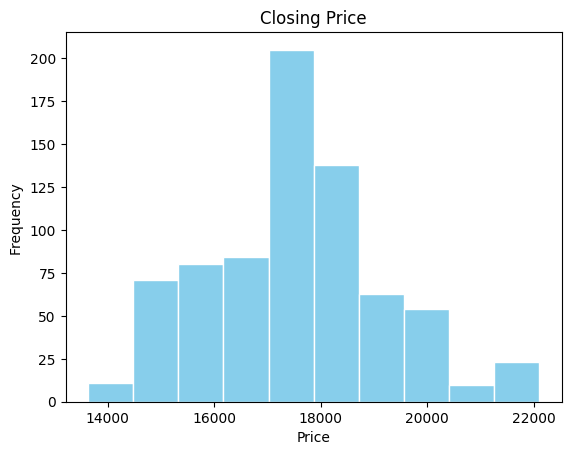

In [19]:
#seeing the distribution of the closing price
x = df['Close']
plt.hist(x, color='skyblue', edgecolor = 'white')
plt.xlabel("Price")
plt.ylabel("Frequency ")
plt.title("Closing Price")
plt.show()

Text(0.5, 1.0, 'Closing price graph')

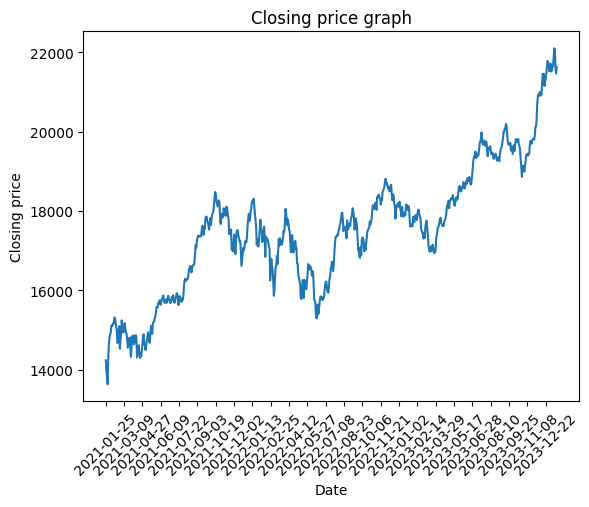

In [20]:
#line graph for the closing price
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price')
tick_indices = range(0, len(df['Date']), 30)
plt.xticks(df['Date'][tick_indices], rotation=45)
plt.title('Closing price graph')

In [21]:
#minimum and maximum values of the closing price
x_max = max(x)
x_min = min(x)
print(f'Min closing price : {x_min}, Max closing price : {x_max}')

Min closing price : 13634.599609, Max closing price : 22097.449219


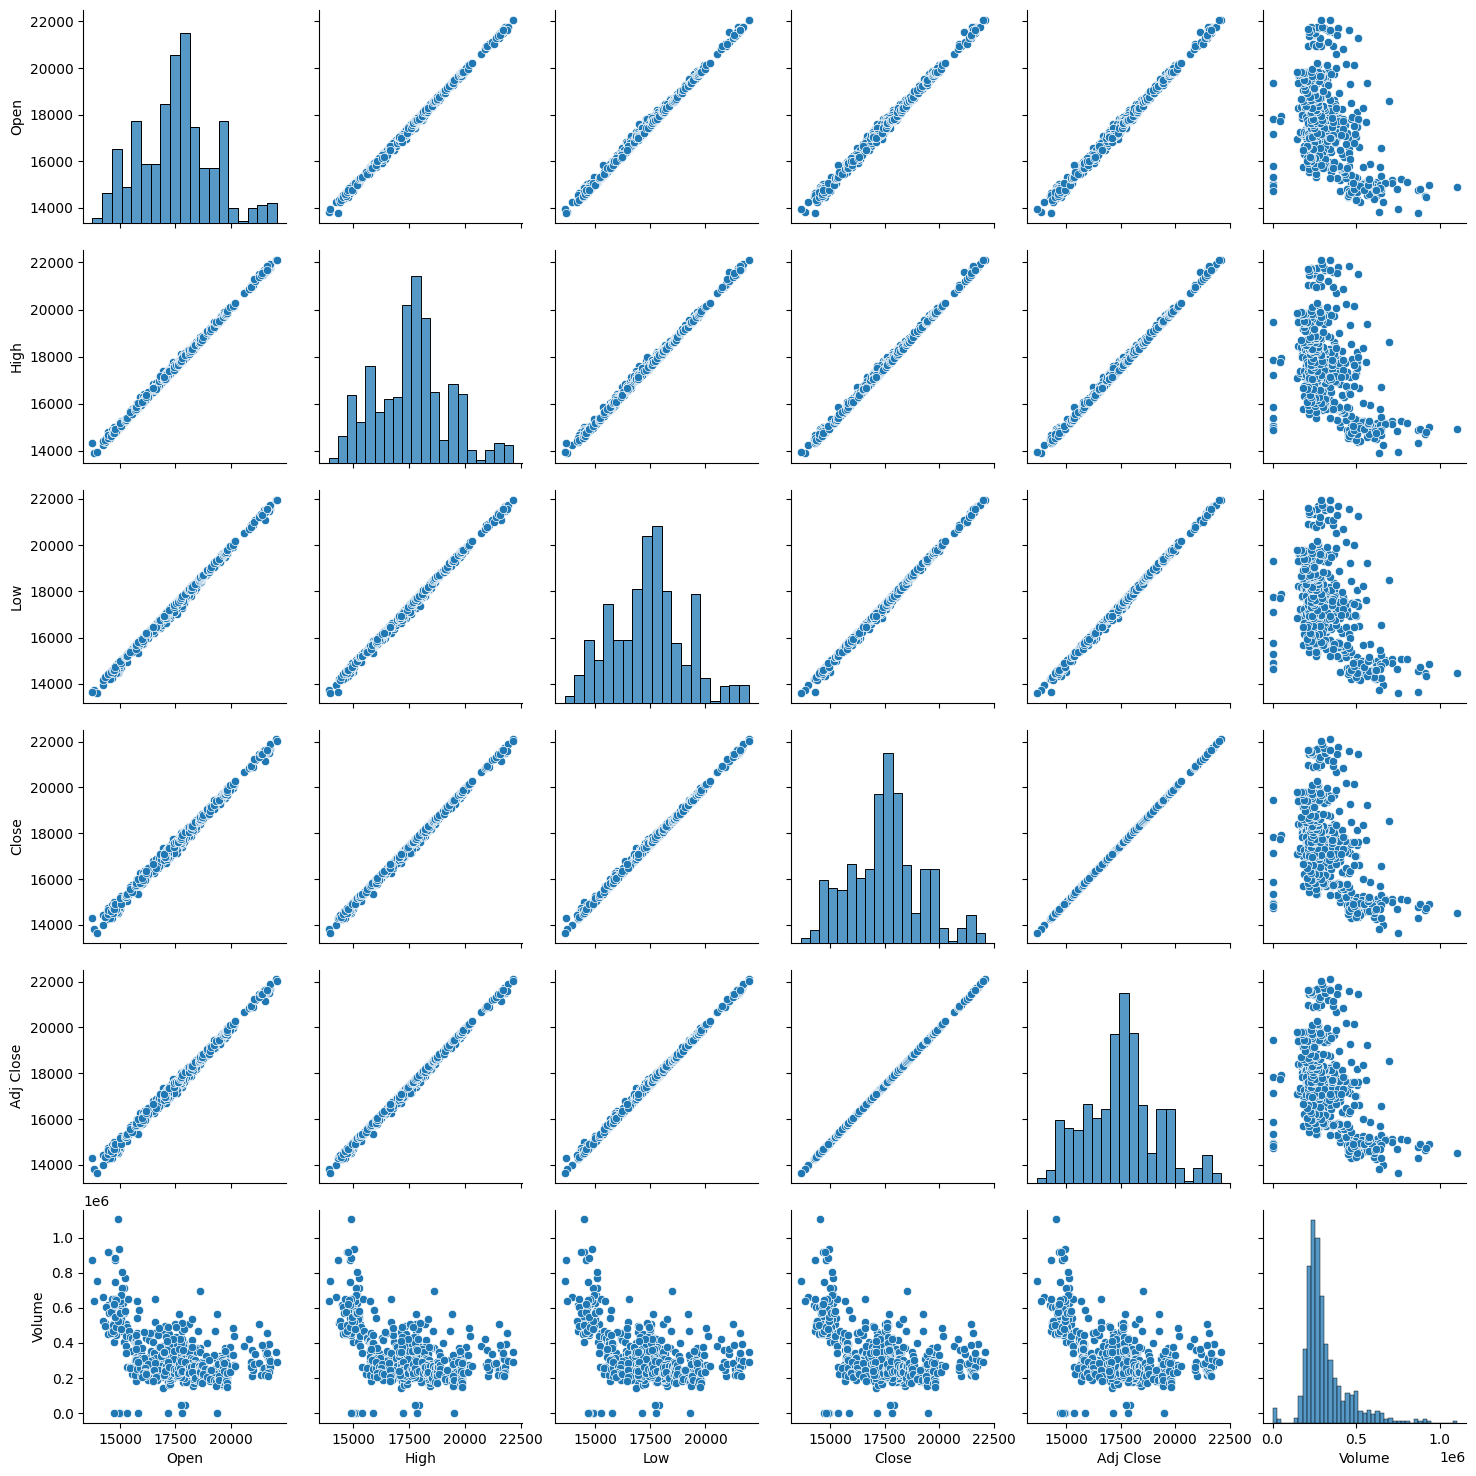

In [22]:
sns.pairplot(df)
plt.show()

# Calculating indicators


In [23]:
#creating a class for all the tasks related to technical indicators
class TechnicalIndicators:
    def __init__(self, data):
        self.data = data
        self.calculate_indicators()

    def calculate_indicators(self):
        # Calculate Moving Average (MA)
        self.data['MA_20'] = self.data['Close'].rolling(window=20).mean() #taking the window as 20 days
        # self.data['MA_200'] = self.data['Close'].rolling(window=200).mean()

        # Calculate Relative Strength Index (RSI)
        delta = self.data['Close'].diff()                        #calculates the difference between each element and its preceding element in the series
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=10, min_periods=1).mean()
        avg_loss = loss.rolling(window=10, min_periods=1).mean()
        rs = avg_gain / avg_loss
        self.data['RSI'] = 100 - (100 / (1 + rs))

        # Calculate Bollinger Bands
        self.data['Upper_band'] = self.data['MA_20'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['Lower_band'] = self.data['MA_20'] - 2 * self.data['Close'].rolling(window=20).std()

        # Calculate Moving Average Convergence Divergence (MACD)
        self.data['EMA_12'] = self.data['Close'].ewm(span=12, adjust=False).mean()
        self.data['EMA_26'] = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = self.data['EMA_12'] - self.data['EMA_26']
        # Also finding the Signal Line
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

    def correlation_analysis(self):
        # Perform correlation analysis
        correlation_matrix = self.data[['MA_20', 'RSI', 'Upper_band', 'Lower_band', 'MACD', 'Signal_Line']].corr()
        return correlation_matrix

    def combined_indicator(self):
        # Calculate weighted average of indicators based on correlations
        correlation_matrix = self.data[['MA_20', 'RSI', 'Upper_band', 'Lower_band', 'MACD', 'Signal_Line']].corr()

        # Giving weights to indicators in accordance with the correlations that we get
        # Indicators with more correlation have more weights
        weights = correlation_matrix.abs().sum()

        # Normalizing weights
        weights = weights / weights.sum()

        # Calculate the combined indicator using the weights that we calculated
        self.data['Combined_Indicator'] = (
            weights['MA_20'] * self.data['MA_20'] +
            weights['RSI'] * self.data['RSI'] +
            weights['Upper_band'] * self.data['Upper_band'] +
            weights['Lower_band'] * self.data['Lower_band'] +
            weights['MACD'] * self.data['MACD'] +
            weights['Signal_Line'] * self.data['Signal_Line']
        )

    def predict_positions(self):
        # Create a binary classification problem (Bullish: 1, Bearish: 0)
        self.data['Position'] = np.where(self.data['Close'].shift(-1) > self.data['Close'], 1, 0)
        # additional column for prediction with value 'L' for long and 'S' for short.
        self.data['Prediction'] = np.where(self.data['Position'] == 1, 'L', 'S')


        # Prepare features and labels for the model
        #X = self.data[['MA_20', 'RSI', 'Upper_band', 'Lower_band', 'MACD', 'Signal_Line', 'Combined_Indicator']]
        X=self.data[['Combined_Indicator']]
        y = self.data['Position']

        # Handle missing values by Forward and Backward fills
        X.fillna(method='ffill', inplace=True)  # Forward-fill missing values
        X.fillna(method='bfill', inplace=True)  # Backward-fill any remaining missing values

        # Scale input features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

        # Training the SVM model
        svm_model = SVC()
        svm_model.fit(X_train, y_train)

        # Training RandomForest model
        rf_model = RandomForestClassifier()
        rf_model.fit(X_train, y_train)

        # Evaluate models
        svm_predictions = svm_model.predict(X_test)
        rf_predictions = rf_model.predict(X_test)

        # Calculate accuracy for each model
        accuracy_svm = accuracy_score(y_test, svm_predictions)
        accuracy_rf = accuracy_score(y_test, rf_predictions)
        print("Accuracy of SVM:", accuracy_svm)
        print("Accuracy of RandomForest:", accuracy_rf)

        # Training Logistic Regression model
        lr_model = LogisticRegression(random_state=42)
        lr_model.fit(X_train, y_train)

        # Evaluate Logistic Regression model
        lr_predictions = lr_model.predict(X_test)
        accuracy_lr = accuracy_score(y_test, lr_predictions)
        print("Accuracy of Logistic Regression:", accuracy_lr)

        xgb_model = XGBClassifier(random_state=42)
        xgb_model.fit(X_train, y_train)

        # Evaluate XGBoost model
        xgb_predictions = xgb_model.predict(X_test)
        accuracy_xgb = accuracy_score(y_test, xgb_predictions)
        print("Accuracy of XGBoost:", accuracy_xgb)

indicators = TechnicalIndicators(df)
indicators.combined_indicator()
indicators.predict_positions()


Accuracy of SVM: 0.5135135135135135
Accuracy of RandomForest: 0.6216216216216216
Accuracy of Logistic Regression: 0.545045045045045
Accuracy of XGBoost: 0.5990990990990991


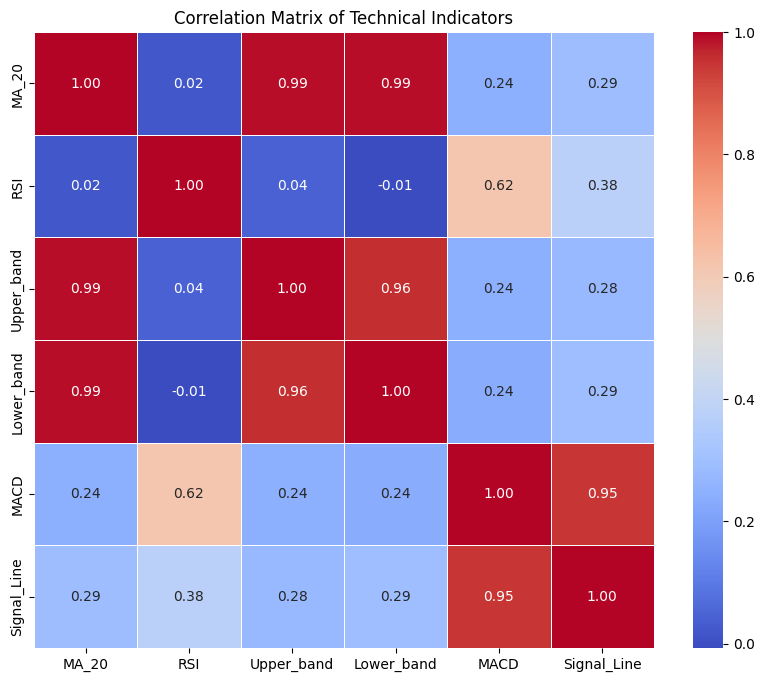

In [24]:
# Correlation analysis of the indicators
indicators = TechnicalIndicators(df)
r = indicators.correlation_analysis()
plt.figure(figsize=(10, 8))
sns.heatmap(r, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Technical Indicators')
plt.show()

In [25]:
#New dataframe with the added columns for inidcators along with the Prediction column
df

,Date,Open,High,Low,Close,Adj Close,Volume,MA_20,RSI,Upper_band,Lower_band,EMA_12,EMA_26,MACD,Signal_Line,Combined_Indicator,Position,Prediction
0,2021-01-25,14477.799805,14491.099609,14218.599609,14238.900391,14238.900391,618600.0,NaN,NaN,NaN,NaN,14238.900391,14238.900391,0.000000,0.000000,NaN,0,S
1,2021-01-27,14237.950195,14237.950195,13929.299805,13967.500000,13967.500000,660700.0,NaN,0.000000,NaN,NaN,14197.146485,14218.796658,-21.650174,-4.330035,NaN,0,S
2,2021-01-28,13810.400391,13898.250000,13713.250000,13817.549805,13817.549805,637900.0,NaN,0.000000,NaN,NaN,14138.746996,14189.074669,-50.327674,-13.529563,NaN,0,S
3,2021-01-29,13946.599609,13966.849609,13596.750000,13634.599609,13634.599609,753200.0,NaN,0.000000,NaN,NaN,14061.185859,14148.002443,-86.816583,-28.186967,NaN,1,L
4,2021-02-01,13758.599609,14336.349609,13661.750000,14281.200195,14281.200195,870500.0,NaN,51.690773,NaN,NaN,14095.034218,14157.868943,-62.834724,-35.116518,NaN,1,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2024-01-15,22053.150391,22115.550781,21963.550781,22097.449219,22097.449219,345500.0,21577.875000,65.383409,22013.408169,21142.341831,21678.838592,21362.507955,316.330637,333.293324,12038.539759,0,S
736,2024-01-16,22080.500000,22124.150391,21969.800781,22032.300781,22032.300781,292400.0,21606.657519,65.408213,22082.663300,21130.651739,21733.217390,21412.122239,321.095152,330.853689,12054.910206,0,S
737,2024-01-17,21647.250000,21851.500000,21550.449219,21571.949219,21571.949219,456000.0,21614.322461,51.818531,22082.453144,21146.191778,21708.406903,21423.961274,284.445628,321.572077,12049.799382,0,S
738,2024-01-18,21414.199219,21539.400391,21285.550781,21462.250000,21462.250000,387300.0,21614.779980,43.319853,22082.264658,21147.295303,21670.536610,21426.797476,243.739134,306.005489,12039.515465,1,L


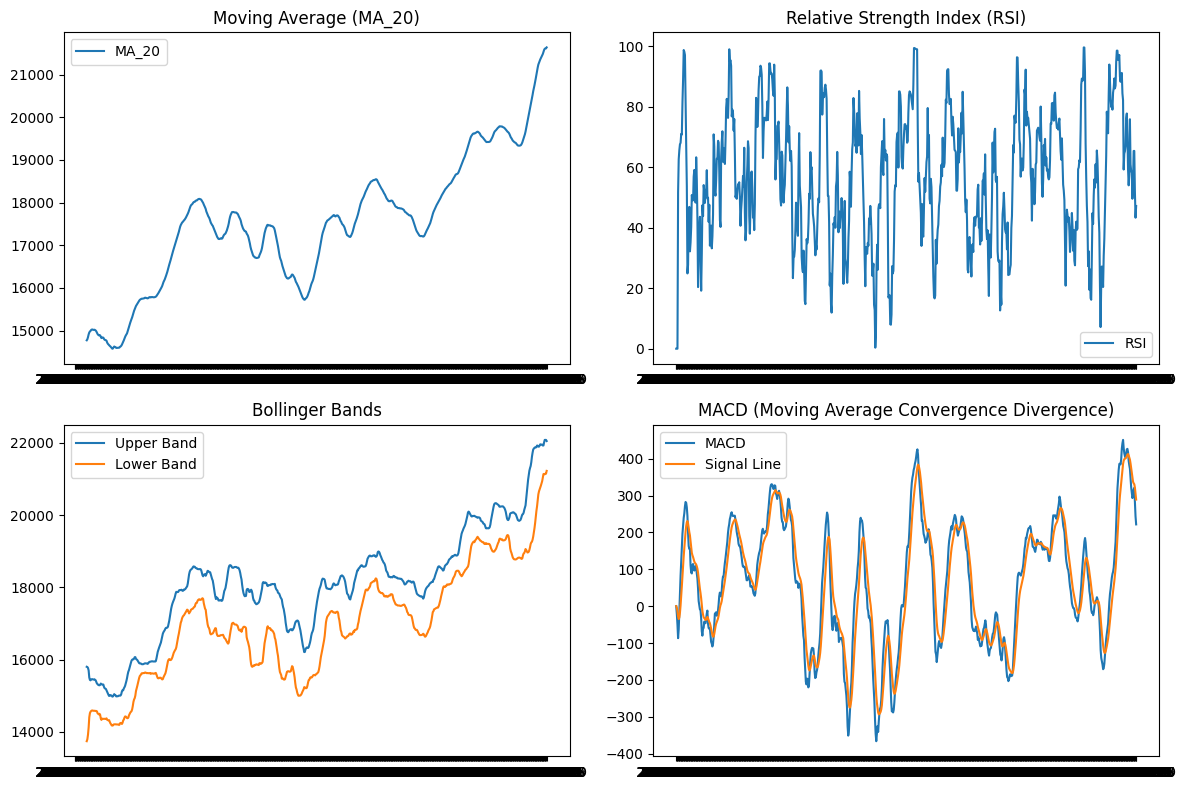

In [34]:
plt.figure(figsize=(12, 8))

# Moving Average
plt.subplot(2, 2, 1)
plt.plot(df['Date'], df['MA_20'], label='MA_20')
plt.title('Moving Average (MA_20)')
plt.legend()

# Relative Strength Index (RSI)
plt.subplot(2, 2, 2)
plt.plot(df['Date'], df['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Bollinger Bands
plt.subplot(2, 2, 3)
plt.plot(df['Date'], df['Upper_band'], label='Upper Band')
plt.plot(df['Date'], df['Lower_band'], label='Lower Band')
plt.title('Bollinger Bands')
plt.legend()

# MACD
plt.subplot(2, 2, 4)
plt.plot(df['Date'], df['MACD'], label='MACD')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.legend()

plt.tight_layout()
plt.show()


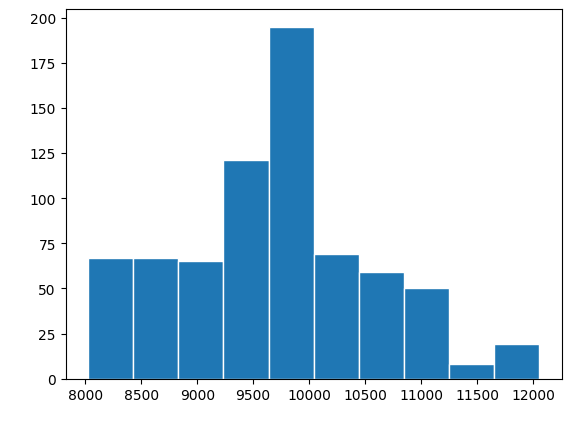

In [27]:
plt.hist(df['Combined_Indicator'], edgecolor = 'white')
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

In [28]:
df.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
MA_20                 19
RSI                    1
Upper_band            19
Lower_band            19
EMA_12                 0
EMA_26                 0
MACD                   0
Signal_Line            0
Combined_Indicator    19
Position               0
Prediction             0
dtype: int64

In [31]:
df.to_csv('results.csv')
!cp results.csv "/content/drive/My Drive/"

cp: cannot create regular file '/content/drive/My Drive/': No such file or directory
